In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import time
from torch import Tensor
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from typing import Iterable
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from matplotlib.colors import LinearSegmentedColormap
from joblib import dump, load

import sys

In [2]:
site = 'C'

In [3]:
# load the data
# get parent directory
os.chdir("../..")
data_directory = 'Data_clean'
data_name = site + '_data_clean.csv'

data = pd.read_csv(os.path.join(os.getcwd(), data_directory, data_name), index_col = 0)

# reset to current directory
fd = sys.path[0]
os.chdir(fd)

In [4]:
# drop irrelevant columns
data = data.drop(columns = ['Wind_speed_sd', 'Temperature'])

In [5]:
# Add week number
data['ts'] = pd.to_datetime(data['ts'], format = '%Y-%m-%d %H:%M:%S')
data['Week'] = data.ts.dt.isocalendar().week

# Rearrange columns
data = data.reindex(columns = ['ts', 'Month', 'Day', 'Hour', 'Week', 'instanceID', 'Wind_speed', 'TI', 'Power'])

In [6]:
# load normalization function 
scaler1 = load('scaler1.bin')
scaler2 = load('scaler2.bin')

C:\Users\User\anaconda3\lib\site-packages\sklearn\base.py:310: UserWarning: Trying to unpickle estimator StandardScaler from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


In [7]:
class Net(nn.Module):
    def __init__(self, dims: Iterable[int], output_activation: nn.Module = None):
        """Creates a network using ReLUs between layers and no activation at the end

        :param dims (Iterable[int]): tuple in the form of (IN_SIZE, HIDDEN_SIZE, HIDDEN_SIZE2,
            ..., OUT_SIZE) for dimensionalities of layers
        :param output_activation (nn.Module): PyTorch activation function to use after last layer
        """
        super().__init__()
        self.input_size = dims[0]
        self.out_size = dims[-1]
        self.layers = self.make_seq(dims, output_activation)

    @staticmethod
    def make_seq(dims: Iterable[int], output_activation: nn.Module) -> nn.Module:
        """Creates a sequential network using ReLUs between layers and no activation at the end

        :param dims (Iterable[int]): tuple in the form of (IN_SIZE, HIDDEN_SIZE, HIDDEN_SIZE2,
            ..., OUT_SIZE) for dimensionalities of layers
        :param output_activation (nn.Module): PyTorch activation function to use after last layer
        :return (nn.Module): return created sequential layers
        """
        mods = []

        for i in range(len(dims) - 2):
            mods.append(nn.Linear(dims[i], dims[i + 1]))
            mods.append(nn.ReLU())

        mods.append(nn.Linear(dims[-2], dims[-1]))
        if output_activation:
            mods.append(output_activation())
        return nn.Sequential(*mods)
    
    def forward(self, x: Tensor) -> Tensor:
        """Computes a forward pass through the network

        :param x (torch.Tensor): input tensor to feed into the network
        :return (torch.Tensor): output computed by the network
        """
        # Feedforward
        return self.layers(x)


In [8]:
# load the trained weights
checkpoint_median = torch.load(sys.path[0] + '/median.pth')
checkpoint_UQ = torch.load(sys.path[0] + '/UQ.pth')
checkpoint_LQ = torch.load(sys.path[0] + '/LQ.pth')

# define network architecture 
net_median = Net(dims = (2, 16, 16, 16, 16, 1))
net_UQ = Net(dims = (2, 16, 16, 16, 16, 1))
net_LQ = Net(dims = (2, 16, 16, 16, 16, 1))

In [9]:
data.iloc[:, 6:-1]

,Wind_speed,TI
1,4.062859,11.707602
3,4.695373,15.176091
4,3.614577,15.750575
5,3.526409,19.338555
6,4.067837,15.708470
...,...,...
1106799,7.277958,8.877151
1106800,3.293306,24.411169
1106802,6.826774,11.834653
1106803,6.148926,12.236465


In [10]:
%%time
#################################################### predict ######################################################### 

turbines = data.instanceID.unique()
results = pd.DataFrame

for ID in turbines:
    
    # select data based on turbine ID
    data_temp = data[data['instanceID'] == ID]
    
    # normalize data
    X = data_temp.iloc[:, 6:-1].values
    X = scaler1.transform(X)
    
    # load model based on turbine number
    net_median.load_state_dict(checkpoint_median[ID])
    net_UQ.load_state_dict(checkpoint_UQ[ID])
    net_LQ.load_state_dict(checkpoint_LQ[ID])

    # predict
    median = net_median(Tensor(X))
    median = scaler2.inverse_transform(median.detach().numpy()).flatten()
    UQ = net_UQ(Tensor(X))
    UQ = scaler2.inverse_transform(UQ.detach().numpy()).flatten()
    LQ = net_LQ(Tensor(X))
    LQ = scaler2.inverse_transform(LQ.detach().numpy()).flatten()

    data_temp = pd.concat([data_temp, pd.Series(median, index = data_temp.index.values, name = 'Predicted_power'), 
                           pd.Series(UQ, index = data_temp.index.values, name = 'UQ'), 
                           pd.Series(LQ, index = data_temp.index.values, name = 'LQ')], axis = 1)
    
    if results.empty: 
        results = data_temp
    else:
        results = pd.concat([results, data_temp], axis = 0)
    
    print('Done ', ID)

Done  C_WTG02
Done  C_WTG04
Done  C_WTG05
Done  C_WTG06
Done  C_WTG07
Done  C_WTG08
Done  C_WTG09
Done  C_WTG12
Done  C_WTG13
Done  C_WTG17
Done  C_WTG16
Done  C_WTG21
Done  C_WTG10
Done  C_WTG11
Done  C_WTG01
Done  C_WTG18
Done  C_WTG19
Done  C_WTG14
Done  C_WTG15
Done  C_WTG20
Done  C_WTG03
Wall time: 2.35 s


In [11]:
results.head()

,ts,Month,Day,Hour,Week,instanceID,Wind_speed,TI,Power,Predicted_power,UQ,LQ
1,2020-01-01 00:00:00,1,1,0,1,C_WTG02,4.062859,11.707602,144.951967,125.987770,190.274948,73.853493
22,2020-01-01 00:10:00,1,1,0,1,C_WTG02,4.846914,14.856238,241.911755,262.231354,366.132629,176.129196
43,2020-01-01 00:20:00,1,1,0,1,C_WTG02,4.945137,11.742346,252.295768,265.636627,370.704742,182.983017
64,2020-01-01 00:30:00,1,1,0,1,C_WTG02,5.251834,10.815515,287.445673,329.754150,447.936249,234.738144
85,2020-01-01 00:40:00,1,1,0,1,C_WTG02,5.313850,10.067187,340.274619,338.087250,460.867340,243.267807


In [12]:
# create dataframe for the results
results_all = results.assign(PI_width = results['UQ'] - results['LQ'])
results_all = results_all.assign(Error = results_all['Predicted_power'] - results_all['Power'])

# classify outlier 
results_all['Outlier_pred'] = (results_all['Power'] < results_all['LQ']) | (results_all['Power'] > results_all['UQ'])
results_all['Under_pred'] = (results_all['Power'] < results_all['LQ'])
results_all['Over_pred'] = (results_all['Power'] > results_all['UQ'])
results_all['Sample_count'] = 1

In [13]:
# create dataframe for normal and outlier data     
outlier_all = results_all[(results_all['Under_pred'] == 1) | (results_all['Over_pred'] == 1)]
outlier_under = results_all[results_all['Under_pred'] == 1]
outlier_over = results_all[results_all['Over_pred'] == 1]

In [14]:
# performance
q = 0.5
residual = results_all['Predicted_power'] - results_all['Power']
m = residual > 0
qloss = (m*(q*residual) + (1-m)*((q-1)*residual)).mean()

MSE = metrics.mean_squared_error(results_all['Power'], results_all['Predicted_power'])
RMSE = np.sqrt(metrics.mean_squared_error(results_all['Power'], results_all['Predicted_power']))
MAE = metrics.mean_absolute_error(results_all['Power'], results_all['Predicted_power'])
MedAE = metrics.median_absolute_error(results_all['Power'], results_all['Predicted_power'])

print('Quantile loss at', q, ':', qloss)
print('MSE:', MSE)
print('RMSE:', RMSE)
print('MAE:', MAE)
print('MedAE:', MedAE)

Quantile loss at 0.5 : 20.776262212866122
MSE: 3608.379764557223
RMSE: 60.06979078170011
MAE: 41.55252442573224
MedAE: 26.997881158192545


In [15]:
# performance
q = 0.025
qloss = (m*(q*residual) + (1-m)*((q-1)*residual)).mean()
print('Quantile loss at', q, ':', qloss)

q = 0.975
qloss = (m*(q*residual) + (1-m)*((q-1)*residual)).mean()
print('Quantile loss at', q, ':', qloss)

Quantile loss at 0.025 : 21.13454864130532
Quantile loss at 0.975 : 20.30375949595717


In [27]:
# we want PICP near 0.95, narrow NMPIW, and low CWC
PICP = (1 - len(outlier_all)/len(results_all))
coverage_LWL = (1 - len(outlier_under)/len(results_all))*100
coverage_UWL = (1 - len(outlier_over)/len(results_all))*100
max_power = results_all['Power'].max()
min_power = results_all['Power'].min()
NMPIW = results_all['PI_width'].mean()/(max_power-min_power)
mu = 1-0.05
gamma = PICP < mu
CWC = NMPIW * (1 + (gamma * PICP * np.exp(-0.2*(PICP-mu))))

print('We have 95% PI. The percentage of data points fall within the 95% PI is ', round(PICP*100, 2),'%.')
print('The percentage of data points fall below the 0.025 quantile is ', round(100-coverage_LWL, 2),'%.')
print('The percentage of data points fall above the 0.975 quantile is ', round(100-coverage_UWL,2),'%.')
print('The normalized mean PI width is', round(NMPIW, 4))
print('The coverage width-based criterion, CWC is', round(CWC, 4))

We have 95% PI. The percentage of data points fall within the 95% PI is  94.61 %.
The percentage of data points fall below the 0.025 quantile is  2.69 %.
The percentage of data points fall above the 0.975 quantile is  2.7 %.
The normalized mean PI width is 0.099
The coverage width-based criterion, CWC is 0.1928


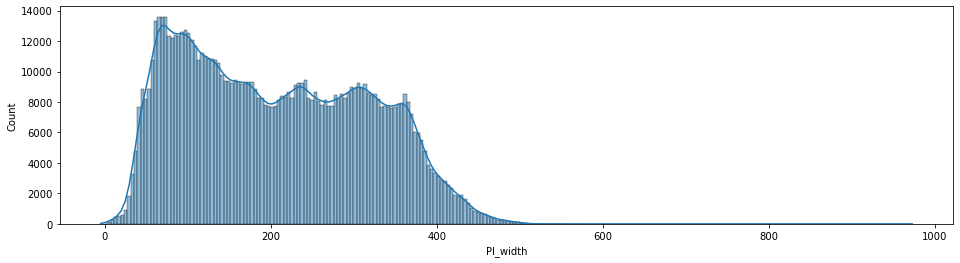

In [46]:
fig, ax = plt.subplots(figsize = (16,4))
sns.histplot(data = results_all, x = 'PI_width', kde=True)
plt.show()

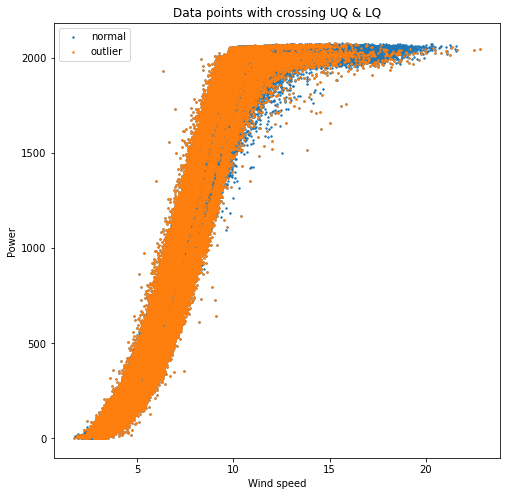

In [47]:
# plot outliers
plt.subplots(figsize = (8,8))
plt.scatter(results_all['Wind_speed'], results_all['Power'], s = 2, label = 'normal')
plt.scatter(outlier_all['Wind_speed'], outlier_all['Power'], s = 2, label = 'outlier')
plt.xlabel('Wind speed')
plt.ylabel('Power')
plt.legend()
plt.title('Data points with crossing UQ & LQ')
plt.show()

#### Mean PI width vs wind speed

In [48]:
print("max wind speed: ", results_all['Wind_speed'].min())
print("max wind speed: ", results_all['Wind_speed'].max())

max wind speed:  1.72172202865283
max wind speed:  22.7935141245524


In [49]:
# define lists to bin the wind speed by 0.5 m/s
Wind_speed_bin = np.linspace(1, 23, 23)
Wind_speed_start = np.linspace(1, 22, 22)
Wind_speed_end = np.linspace(2, 23, 22)
Wind_speed_range = ['1-2', '2-3', '3-4', '4-5', '5-6', '6-7', '7-8', '8-9', '9-10', '10-11', '11-12', 
                    '12-13', '13-14', '14-15', '15-16', '16-17', '17-18', '18-19', '19-20', '20-21', '21-22', '22-23']


In [50]:
PI_windspeed_trends = pd.DataFrame()
for i in range (len(Wind_speed_start)):
    temp_data = results_all[(results_all['Wind_speed'] >= Wind_speed_start[i]) & 
                        (results_all['Wind_speed'] < Wind_speed_end[i])]
    
    sample_count = len(temp_data)
    
    if (sample_count == 0): 
        RMSE = np.nan 
        PI_width_mean = np.nan 
    
    else:
        RMSE = np.sqrt(metrics.mean_squared_error(temp_data['Power'], temp_data['Predicted_power']))
        PI_width_mean = temp_data['PI_width'].mean()
     
    PI_windspeed_trend = pd.DataFrame([Wind_speed_range[i], sample_count, RMSE, PI_width_mean], 
                              index = ['Wind_speed_range', 'Sample_count', 'RMSE', 'PI_width_mean']).T
    if PI_windspeed_trends.empty:
        PI_windspeed_trends = PI_windspeed_trend

    else:
        PI_windspeed_trends = pd.concat([PI_windspeed_trends, PI_windspeed_trend])

PI_windspeed_trends = PI_windspeed_trends.reset_index(drop=True)
        
PI_windspeed_trends   

,Wind_speed_range,Sample_count,RMSE,PI_width_mean
0,1-2,13,29.596159,47.062675
1,2-3,22153,12.556874,55.369125
2,3-4,108209,20.175893,77.734169
3,4-5,136014,33.65118,128.74527
4,5-6,137427,53.252452,199.998062
5,6-7,118469,71.509477,274.450409
6,7-8,94510,85.878895,328.701935
7,8-9,71275,93.487586,360.0625
8,9-10,56338,82.461314,307.976166
9,10-11,41599,55.026921,198.29541


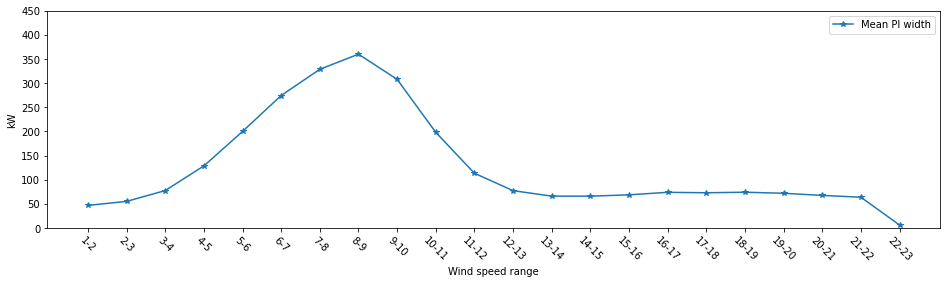

In [51]:
fig, ax = plt.subplots(figsize = (16,4))
ax.plot(PI_windspeed_trends['PI_width_mean'], label = 'Mean PI width', marker = '*')
ax.axes.set_xticks(ticks = PI_windspeed_trends.index.values)
ax.axes.set_xticklabels(Wind_speed_range)
ax.set_xlabel('Wind speed range')
plt.xticks(rotation = -45)
plt.ylim([0, 450])
plt.ylabel('kW')
# plt.title('Quantile Regression with Artificial Neural Network')
plt.legend()
plt.show()

#### Mean PI width vs TI

In [52]:
print("max TI: ", results_all['TI'].min())
print("max TI: ", results_all['TI'].max())

max TI:  0.0
max TI:  155.963232304619


In [53]:
TI_bin = np.linspace(1, 12, 12)
TI_start = np.linspace(0, 55, 12)
TI_end = np.linspace(5, 60, 12)
TI_range = ['0-5', '5-10', '10-15', '15-20', '20-25', '25-30', '30-35', '35-40', '40-45', '45-50', 
                    '50-55', '55-60']

In [54]:
PI_TI_trends = pd.DataFrame()
for i in range (len(TI_start)):
    temp_data = results_all[(results_all['TI'] >= TI_start[i]) & 
                        (results_all['TI'] < TI_end[i])]
    
    sample_count = len(temp_data)
    if (sample_count == 0):
        RMSE = np.nan 
        PI_width_mean = np.nan 
    
    else:
        RMSE = np.sqrt(metrics.mean_squared_error(temp_data['Power'], temp_data['Predicted_power']))
        PI_width_mean = temp_data['PI_width'].mean()

    PI_TI_trend = pd.DataFrame([TI_range[i], sample_count, RMSE, PI_width_mean], 
                                  index = ['TI_range', 'Sample_count', 'RMSE', 'PI_width_mean']).T
    if PI_TI_trends.empty:
        PI_TI_trends = PI_TI_trend

    else:
        PI_TI_trends = pd.concat([PI_TI_trends, PI_TI_trend])

PI_TI_trends = PI_TI_trends.reset_index(drop=True)

PI_TI_trends   

,TI_range,Sample_count,RMSE,PI_width_mean
0,0-5,1554,58.474873,176.362335
1,5-10,104083,58.986305,200.306
2,10-15,314311,61.292599,209.439041
3,15-20,273090,60.66213,209.655701
4,20-25,118926,57.758171,199.63385
5,25-30,32153,54.427455,183.33551
6,30-35,6550,51.912789,180.997772
7,35-40,1396,59.418977,205.756454
8,40-45,311,93.799832,260.720245
9,45-50,86,70.665785,286.242493


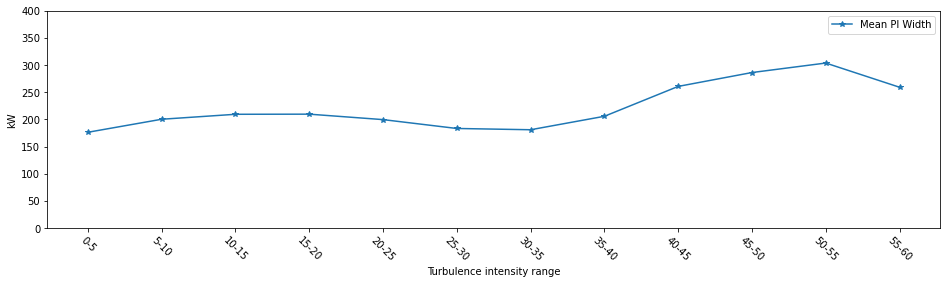

In [55]:
fig, ax = plt.subplots(figsize = (16,4))
ax.plot(PI_TI_trends['PI_width_mean'], label = 'Mean PI Width', marker = '*')
ax.axes.set_xticks(ticks = PI_TI_trends.index.values)
ax.axes.set_xticklabels(TI_range)
ax.set_xlabel('Turbulence intensity range')
plt.xticks(rotation = -45)
# plt.title('Quantile Regression with Neural Network')
plt.ylabel('kW')
plt.ylim([0, 400])
plt.legend()
plt.show()

### Create pivot and heatmap

In [15]:
results_all_pivot = pd.pivot_table(results_all, values=['Sample_count', 'Outlier_pred', 'Under_pred', 'Over_pred'], 
                                   index=['instanceID', 'Week'],
                                   aggfunc={'Sample_count': np.sum, 
                                            'Outlier_pred': np.sum, 
                                            'Under_pred': np.sum, 
                                            'Over_pred': np.sum})
results_all_pivot

Outlier_pred  Over_pred  Sample_count  Under_pred
instanceID Week                                                   
C_WTG01    1               11         11           707           0
           2               23          9           805          14
           3               80         67           914          13
           4               19         16           929           3
           5               41         29           849          12
...                       ...        ...           ...         ...
C_WTG21    49              52         34           553          18
           50              52         39           807          13
           51               7          1           934           6
           52              75         37           769          38
           53              64         41           500          23

[1105 rows x 4 columns]

In [16]:
# drop rows with insignificant sample count 
min_samples =  252
idx = results_all_pivot[results_all_pivot['Sample_count'] < min_samples].index
results_all_pivot = results_all_pivot.drop(idx)

In [17]:
# define threshold
L0_threshold = 0.1
L1_threshold = 0.2
L2_threshold = 0.3

In [18]:
# assign warning levels
results_all_pivot['Outlier_ratio'] = results_all_pivot['Outlier_pred']/results_all_pivot['Sample_count']
results_all_pivot['Over_ratio'] = results_all_pivot['Over_pred']/results_all_pivot['Sample_count']
results_all_pivot['Under_ratio'] = results_all_pivot['Under_pred']/results_all_pivot['Sample_count']

results_all_pivot['Level_0'] = results_all_pivot['Outlier_ratio'] <= L0_threshold
results_all_pivot['Level_1'] = (results_all_pivot['Outlier_ratio'] > L0_threshold) & (results_all_pivot['Outlier_ratio'] <= L1_threshold)
results_all_pivot['Level_2'] = (results_all_pivot['Outlier_ratio'] > L1_threshold) & (results_all_pivot['Outlier_ratio'] <= L2_threshold)
results_all_pivot['Level_3'] = results_all_pivot['Outlier_ratio'] > L2_threshold

results_all_pivot['Level_0_up'] = results_all_pivot['Over_ratio'] <= L0_threshold/2
results_all_pivot['Level_1_up'] = (results_all_pivot['Over_ratio'] > L0_threshold/2) & (results_all_pivot['Over_ratio'] <= L1_threshold/2)
results_all_pivot['Level_2_up'] = (results_all_pivot['Over_ratio'] > L1_threshold/2) & (results_all_pivot['Over_ratio'] <= L2_threshold/2)
results_all_pivot['Level_3_up'] = results_all_pivot['Over_ratio'] > L2_threshold/2

results_all_pivot['Level_0_lo'] = results_all_pivot['Under_ratio'] <= L0_threshold/2
results_all_pivot['Level_1_lo'] = (results_all_pivot['Under_ratio'] > L0_threshold/2) & (results_all_pivot['Under_ratio'] <= L1_threshold/2)
results_all_pivot['Level_2_lo'] = (results_all_pivot['Under_ratio'] > L1_threshold/2) & (results_all_pivot['Under_ratio'] <= L2_threshold/2)
results_all_pivot['Level_3_lo'] = results_all_pivot['Under_ratio'] > L2_threshold/2

results_all_pivot['Level_combined'] = results_all_pivot['Level_1']*1 + results_all_pivot['Level_2']*2 + results_all_pivot['Level_3']*3
results_all_pivot['Level_combined_up'] = results_all_pivot['Level_1_up']*1 + results_all_pivot['Level_2_up']*2 + results_all_pivot['Level_3_up']*3
results_all_pivot['Level_combined_lo'] = results_all_pivot['Level_1_lo']*1 + results_all_pivot['Level_2_lo']*2 + results_all_pivot['Level_3_lo']*3

In [19]:
results_all_pivot = results_all_pivot.reindex(columns = ['Level_combined', 'Level_combined_up', 'Level_combined_lo'])
results_all_pivot = results_all_pivot.reset_index()

In [20]:
# create dummy rows to ensure all weeks appear in heatmap 
for week in range (1, 54): 
    if results_all_pivot[(results_all_pivot['Week'] == week)].empty: 
        new_row = {'instanceID': site + '_WTG01', 'Week':week, 'Level_combined':np.nan, 'Level_combined_up':np.nan, 
                  'Level_combined_lo':np.nan}
        results_all_pivot = results_all_pivot.append(new_row, ignore_index = True)

In [21]:
results_all_pivot

,instanceID,Week,Level_combined,Level_combined_up,Level_combined_lo
0,C_WTG01,1,0,0,0
1,C_WTG01,2,0,0,0
2,C_WTG01,3,0,1,0
3,C_WTG01,4,0,0,0
4,C_WTG01,5,0,0,0
...,...,...,...,...,...
1095,C_WTG21,49,0,1,0
1096,C_WTG21,50,0,0,0
1097,C_WTG21,51,0,0,0
1098,C_WTG21,52,0,0,0


In [67]:
# create separate dataframe for outliers at either/ above UQ/ below LQ
pivot_either = results_all_pivot.pivot(index = 'instanceID', columns = 'Week', values = 'Level_combined')
pivot_up = results_all_pivot.pivot(index = 'instanceID', columns = 'Week', values = 'Level_combined_up')
pivot_lo = results_all_pivot.pivot(index = 'instanceID', columns = 'Week', values = 'Level_combined_lo')

### Heatmap

In [68]:
cat_1 = "Outliers above UQ & below LQ"
cat_2 = "Outliers above UQ"
cat_3 = "Outliers below LQ"

In [69]:
def plot_heatmap(df_pivot, category): 
    
    colors = [(0, 0.85, 0), (1, 1, 0), (1, 0.7, 0), (1, 0, 0)]
    n_bins = 4
    cmap_name = 'cm'
    cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

    fig, ax = plt.subplots(figsize = (20,8))
    ax = sns.heatmap(df_pivot, vmin = 0, vmax = 4, annot = True, cmap = cm, cbar = True, 
                linewidths = 1)

    # customize colorbar
    colorbar = ax.collections[0].colorbar
    colorbar.set_ticks([0.5, 1.5, 2.5, 3.5])
    colorbar.set_ticklabels([0, 1, 2, 3])
    
    plt.yticks(rotation=0) 
    plt.title(category)
    plt.show()

In [ ]:
plot_heatmap(pivot_either, cat_1)

In [ ]:
plot_heatmap(pivot_up, cat_2)

In [ ]:
plot_heatmap(pivot_lo, cat_3)

### Plots 

In [73]:
# define function to plot time series
def plot_time(df_target, df_outlier, turbine, week):
    fig, ax = plt.subplots(figsize = (16, 4))
    ax.plot(df_target['ts'], df_target['Power'], label = 'Measured power')
    ax.plot(df_target['ts'], df_target['UQ'], label = 'UQ')
    ax.plot(df_target['ts'], df_target['LQ'], label = 'LQ')
    ax.scatter(df_outlier['ts'], df_outlier['Power'], color = 'red', label = 'outlier')
    plt.xlabel('Time')
    plt.ylabel('Power, kW')
    plt.title(site + '_WTG' + turbine + ' Week ' + str(week))
    plt.legend()
    plt.show()

In [74]:
# define function to plot power curve
def plot_pcurve(df_turbine, df_target, df_outlier, turbine, week):
    
    colors = np.array([(0.70, 0.85, 1), (0, 0.40, 0.80), (0.80, 0, 0)])
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (16, 6))
    
    ax1.scatter(df_turbine['Wind_speed'], df_turbine['Power'], s = 2, label = site + '_WTG' + turbine, 
                color = colors[0])
    ax1.scatter(df_target['Wind_speed'], df_target['Power'], s = 5, label = 'Week ' + str(week), 
                color = colors[1])
    ax1.set_xlabel('Wind speed, m/s')
    ax1.set_ylabel('Power, kW')
    ax1.legend(loc = 'lower right')
    ax1.grid()
    
    ax2.scatter(df_turbine['Wind_speed'], df_turbine['Power'], s = 2, label = site + "_WTG" + turbine, 
                color = colors[0])
    ax2.scatter(df_outlier['Wind_speed'], df_outlier['Power'], s = 5, label = 'Week ' + str(week) + ' Outlier', 
                color = colors[2])
    ax2.set_xlabel('Wind speed, m/s')
    ax2.set_ylabel('Power, kW')
    ax2.legend(loc = 'lower right')
    ax2.grid()
    plt.show()

In [75]:
def plot_variables (df_turbine, df_target, df_outlier, turbine, week):
    plt.subplots(figsize = (16, 2))
    plt.plot(df_target['ts'], df_target['Temperature'])
    plt.scatter(df_outlier['ts'], df_outlier['Temperature'], label = 'Week ' + str(week) + ' Outlier', 
                color = 'red')
    plt.title('Temperature')
    plt.ylim((df_turbine['Temperature'].min(), df_turbine['Temperature'].max()))
    plt.ylabel('Temperature')
    plt.legend()
    
    plt.subplots(figsize = (16, 2))
    plt.plot(df_target['ts'], df_target['TI'])
    plt.scatter(df_outlier['ts'], df_outlier['TI'], label = 'Week ' + str(week) + ' Outlier', 
                color = 'red')
    plt.title('TI')
    plt.ylim((df_turbine['TI'].min(), df_turbine['TI'].max()))
    plt.ylabel('TI')
    plt.legend()
    
    plt.subplots(figsize = (16, 2))
    plt.plot(df_target['ts'], df_target['Wind_speed'])
    plt.scatter(df_outlier['ts'], df_outlier['Wind_speed'], label = 'Week ' + str(week) + ' Outlier', 
                color = 'red')
    plt.title('Wind speed')
    plt.ylim((df_turbine['Wind_speed'].min(), df_turbine['Wind_speed'].max()))
    plt.ylabel('Wind speed')
    plt.legend()
    
    plt.show()

In [ ]:
# select turbine number and week number to plot
turbine = "12"
week = 8

# create dataframe for plots
df_turbine = results_all[(results_all['instanceID'] == site + "_WTG" + turbine)]

df_target = df_turbine[df_turbine['Week'] == week]
df_outlier = df_target[df_target['Outlier_pred'] >= 1]

# plot
plot_time(df_target, df_outlier, turbine, week)
# plot_variables(df_turbine, df_target, df_outlier, turbine, week)
plot_pcurve(df_turbine, df_target, df_outlier, turbine, week)

### Heteroschedascticity

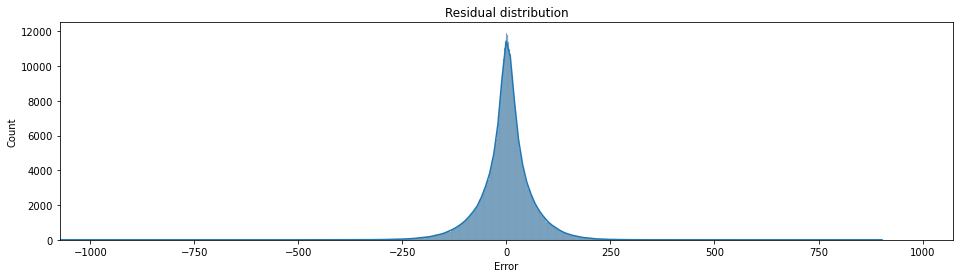

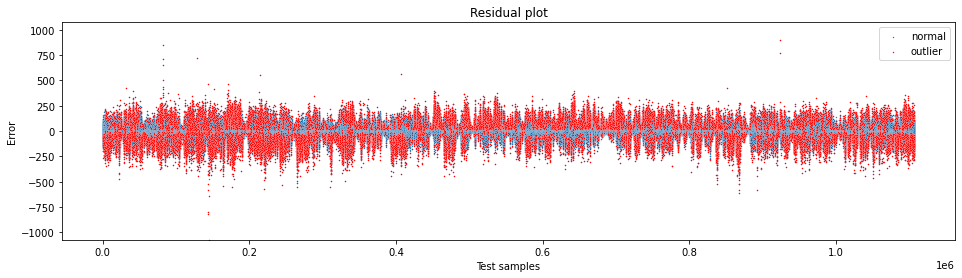

In [85]:
plt.subplots(figsize = (16,4))
sns.histplot(data = results_all, x = 'Error', kde = True)
plt.xlim(-max(abs(results_all.Error.max()), abs(results_all.Error.min())), 
         max(abs(results_all.Error.max()), abs(results_all.Error.min())))
plt.title('Residual distribution')
plt.show()

temp = results_all[results_all['Outlier_pred'] == 1]
plt.subplots(figsize = (16,4))
sns.scatterplot(data = results_all, x = results_all.index.values, y = results_all['Error'], s=2, label = 'normal')
sns.scatterplot(data = temp, x = temp.index.values, y = temp['Error'], color = 'red', s=2, label = 'outlier')
plt.ylim(-max(abs(results_all.Error.max()), abs(results_all.Error.min())), 
         max(abs(results_all.Error.max()), abs(results_all.Error.min())))
plt.xlabel('Test samples')
plt.title('Residual plot')
plt.legend()
plt.show()


In [86]:
temp_data = results_all[results_all['instanceID'] == site + '_WTG01']
temp_outlier = temp_data[(temp_data['Under_pred'] == 1) | (temp_data['Over_pred'] == 1)]

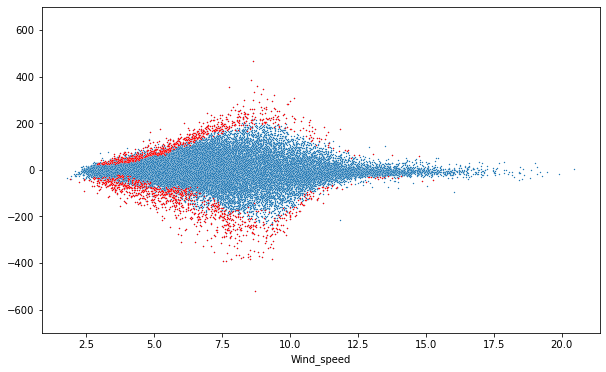

In [87]:
plt.subplots(figsize=(10, 6))
sns.scatterplot(data = temp_data, x = "Wind_speed", y = residual, s = 2)
sns.scatterplot(data = temp_outlier, x = "Wind_speed", y = residual, s = 2, color = "red")
plt.ylim([-700, 700])
plt.show()

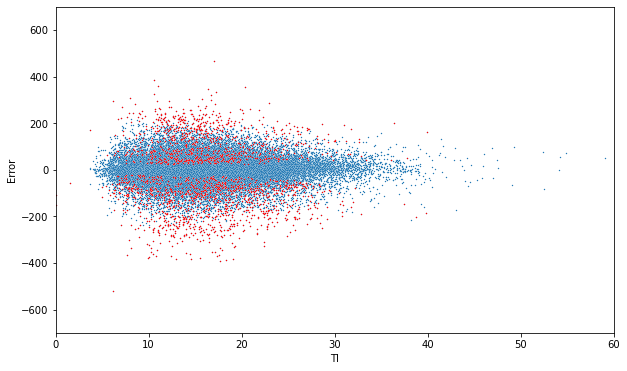

In [88]:
plt.subplots(figsize=(10, 6))
sns.scatterplot(data = temp_data, x = "TI", y = "Error", s = 2)
sns.scatterplot(data = temp_outlier, x = "TI", y = "Error", s = 2, color = "red")
plt.ylim([-700, 700])
plt.xlim([0, 60])
plt.show()